In [1]:
%matplotlib inline
import os
import requests
import urllib 

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from scipy import stats as sps
from sklearn.feature_selection import SelectFromModel
from IPython.display import display
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import halfnorm
import random
import math

In [14]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
from scipy.special import expit
import theano.tensor as T
invlogit = lambda x: 1/(1 + tt.exp(-x))

### Import data

#### 1) Only the data of states with available google trends indexes are included (27 states in total)

In [211]:
data = pd.read_csv("/Users/likehang/Desktop/control.csv")

In [215]:
data.drop(columns = ['ConfirmedCases','cases'], axis = 1, inplace = True)

In [218]:
X = data.iloc[:,np.r_[3:64]]
X = X.apply(pd.to_numeric)

#### 2) Check the null and inf values

In [219]:
data.isnull().values.any()

False

In [220]:
print()
print("printing column name where infinity is present")
col_name = X.columns.to_series()[np.isinf(X).any()]
print(col_name)


printing column name where infinity is present
Series([], dtype: object)


In [221]:
X.drop(columns = ['R_mean'], axis = 1, inplace = True)

In [222]:
y = data.R_mean

### Model Specification¶

In [48]:
invlogit = lambda x: 1/(1 + tt.exp(-x))
def get_model(y, X):
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', .05, shape=X.shape[1]) #inclusion probability for each variable
        alpha = pm.Normal('alpha', mu = 0, sd = 5) # Intercept
        beta = pm.Normal('beta', mu = 0, sd = .75 , shape=X.shape[1]) #Prior for the non-zero coefficients
        p = pm.math.dot(X, xi * beta)#Deterministic function to map the stochastics to the output
        y_obs = pm.Normal('y_obs', invlogit(p + alpha), observed=y)  #Data likelihood
    return model

In [49]:
model1 = get_model(y, X)

In [50]:
print(model1.check_test_point())

xi          -3.13
alpha       -2.53
beta       -38.51
y_obs   -14127.06
Name: Log-probability of test_point, dtype: float64


### Sampling

In [163]:
with model1:
    trace = pm.sample(10000, random_seed = 4816, cores = 1, progressbar = True, chains = 1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 89 seconds.
There were 9652 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [39]:
variables = ['retail', 'grocery_and_pharmacy', 'parks', 'transit_stations',
       'workplaces', 'residential', 'ICU_beds', 'State FIPS', 'NEVER',
       'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Number of Trips 1-10',
       'Number of Trips 10-100', 'Number of Trips >100',
       'Population Not Staying at Home', '0_9', '10_19', '20_29', '30_39',
       '40_49', '50_59', '60_69', '70_79', '80_100', 'prop over 60',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Annual income', 'covid', 'coronavirus',
       'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout',
       'movie ticket', 'restaurant', 'dining out', 'food delivery', 'flight',
       'train', 'uber', 'stay at home', 'work from home', 'Pandemic',
       'Social Distancing', 'Vaccine', 'Zoom', 'home schooling', 'clorox',
       'quarantine', 'grocery', 'covid test', 'outdoor', 'covid symptoms']

### Get results (inclusion probability and beta coefficient for each variable)

In [164]:
results = pd.DataFrame({'var': np.arange(61),
                        'inclusion_probability':np.apply_along_axis(np.mean, 0, trace['xi']),
                       'beta':np.apply_along_axis(np.mean, 0, trace['beta']),
                       'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace['xi']*trace['beta'])
                            /np.apply_along_axis(np.sum, 0, trace['xi'])
                       })

In [165]:
for ind in results.index:
    results['var'][ind] = variables[ind]

<ipython-input-165-562ab08cdc19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['var'][ind] = variables[ind]
/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [166]:
results.sort_values('inclusion_probability', ascending = False).head(40)

,var,inclusion_probability,beta,beta_given_inclusion
6,ICU_beds,0.0926,0.037949,0.343043
17,0_9,0.0916,0.054112,0.506189
19,20_29,0.0893,0.025934,0.500836
14,Number of Trips 10-100,0.0888,0.070632,0.616198
33,Annual income,0.0861,0.013275,0.409596
23,60_69,0.0838,0.053144,0.520085
25,80_100,0.0832,0.051118,0.417895
20,30_39,0.0830,0.025758,0.487082
15,Number of Trips >100,0.0818,0.047959,0.455564
21,40_49,0.0814,0.028553,0.537353


In [167]:
results.to_csv("/Users/likehang/Desktop/results.csv")

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validati

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

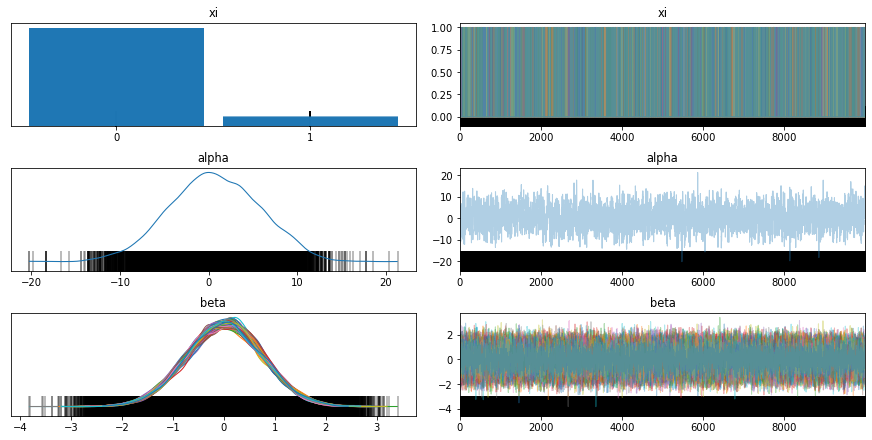

In [168]:
pm.summary(trace)
_ = pm.traceplot(trace)

In [180]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import impute

In [224]:
X = data.iloc[:,np.r_[0, 3:64]]

In [227]:
extraction_settings = ComprehensiveFCParameters()
X_impute = extract_features(X, column_id='State FIPS', column_sort='day_since',
                         default_fc_parameters=extraction_settings,
                         # we impute = remove all NaN features automatically\n",
                         impute_function=impute)

Feature Extraction: 100%|██████████| 20/20 [00:54<00:00,  2.74s/it]


In [229]:
data

,day_since,Date,Cumulative cases,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,ICU_beds,...,Social Distancing,Vaccine,Zoom,home schooling,clorox,quarantine,grocery,covid test,outdoor,covid symptoms
0,1,2020/2/15,0,5,2,39,7,2,-1,9906.178571,...,0,6,3,0,0,0,38,0,39,0
1,2,2020/2/16,0,0,-2,-7,3,-1,1,9906.178571,...,0,23,1,0,0,2,18,0,30,0
2,3,2020/2/17,0,3,0,17,7,-17,4,9906.178571,...,0,5,6,0,0,3,31,0,26,0
3,4,2020/2/18,0,-4,-3,-11,-1,1,2,9906.178571,...,0,26,2,0,0,2,28,0,11,0
4,5,2020/2/19,0,4,1,6,4,1,0,9906.178571,...,0,24,3,0,9,2,35,0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4963,180,2020/8/12,539673,-14,-6,8,-28,-39,12,41844.020410,...,2,76,61,20,27,11,22,28,38,25
4964,181,2020/8/13,546552,-16,-7,14,-27,-40,12,41844.020410,...,6,62,67,0,29,12,50,32,36,21
4965,182,2020/8/14,555394,-18,-7,0,-26,-39,11,41844.020410,...,11,55,57,0,16,12,30,31,47,25
4966,183,2020/8/15,561110,-20,-6,0,-21,-17,5,41844.020410,...,5,54,21,0,16,9,42,18,59,24


In [228]:
X_impute

,50_59__variance_larger_than_standard_deviation,50_59__has_duplicate_max,50_59__has_duplicate_min,50_59__has_duplicate,50_59__sum_values,50_59__abs_energy,50_59__mean_abs_change,50_59__mean_change,50_59__mean_second_derivative_central,50_59__median,...,40_49__permutation_entropy__dimension_5__tau_1,40_49__permutation_entropy__dimension_6__tau_1,40_49__permutation_entropy__dimension_7__tau_1,40_49__query_similarity_count__query_None__threshold_0.0,"40_49__matrix_profile__feature_""min""__threshold_0.98","40_49__matrix_profile__feature_""max""__threshold_0.98","40_49__matrix_profile__feature_""mean""__threshold_0.98","40_49__matrix_profile__feature_""median""__threshold_0.98","40_49__matrix_profile__feature_""25""__threshold_0.98","40_49__matrix_profile__feature_""75""__threshold_0.98"
1,0.0,1.0,1.0,1.0,118493240.0,7.630787e+13,0.0,0.0,0.0,643985.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,1.0,69430376.0,2.619879e+13,0.0,0.0,0.0,377339.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,915050952.0,4.550643e+15,0.0,0.0,0.0,4973103.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,1.0,1.0,129884128.0,9.168417e+13,0.0,0.0,0.0,705892.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,1.0,1.0,95565552.0,4.963465e+13,0.0,0.0,0.0,519378.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,1.0,1.0,1.0,525961792.0,1.503455e+15,0.0,0.0,0.0,2858488.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,1.0,1.0,1.0,243577176.0,3.224448e+14,0.0,0.0,0.0,1323789.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,1.0,1.0,1.0,304421008.0,5.036530e+14,0.0,0.0,0.0,1654462.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,1.0,1.0,1.0,81432512.0,3.603942e+13,0.0,0.0,0.0,442568.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,1.0,1.0,1.0,108044248.0,6.344326e+13,0.0,0.0,0.0,587197.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
from tableone import TableOne, load_dataset
import pandas as pd

In [235]:
y_lst = []
for i in np.arange(183,4968,184):
    if y[i] > 1.01:
        y_lst.append(1)
    else:
        y_lst.append(0)

In [234]:
state = [1, 5, 6, 8, 9, 12, 13, 17, 18, 22, 23, 24, 25, 26, 27, 29, 34, 35, 36, 42, 45, 47, 48, 51, 53, 54, 55]

In [237]:
outcome = pd.DataFrame({'y': y_lst}, index=state)

In [240]:
y_series = outcome.y

In [243]:
X_filtered = select_features(X_impute, y_series)

In [162]:
X = data.iloc[:,np.r_[0, 2:65]]
X.drop(columns = ['cases','R_mean'], axis = 1, inplace = True)

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
X = extract_relevant_features(X, y, column_id='id', column_sort='time')

In [ ]:
weight = pd.read_csv("/Users/likehang/Desktop/results.csv")